M: 16 k: 4
(10000,)
(40000,)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
epoch : 0, loss : 2.86751651763916
epoch : 50, loss : 2.414807081222534
epoch : 100, loss : 2.0702016353607178
epoch : 150, loss : 1.712160587310791
epoch : 200, loss : 1.4086700677871704
epoch : 250, loss : 1.1248646974563599
epoch : 300, loss : 0.9875715970993042
epoch : 350, loss : 0.8299180865287781
epoch : 400, loss : 0.6631419658660889
epoch : 450, loss : 0.5902566313743591
epoch : 500, loss : 0.5022534132003784
epoch : 550, loss : 0.4345606863498688
epoch : 600, loss : 0.34306201338768005
epoch : 650, loss : 0.3131139576435089
epoch : 700, loss : 0.2651679813861847
epoch : 750, loss : 0.2150927484035492
epoch : 800, loss : 0.15999694168567657
epoch : 850, loss : 0.1779135018587112

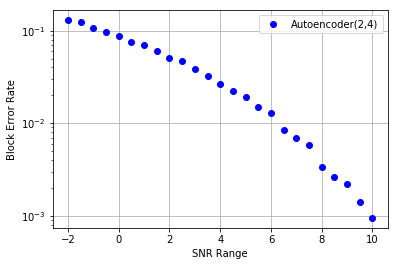

In [320]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.utils.data as Data

n_channel = 2
M = 16
k = int(np.log2(M))
print ('M:',M,'k:',k)
def data_generation(N, M):
    label = np.random.randint(M,size=N)
    print(np.shape(label))

    data = []

    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)
    
    data = np.array(data)
    data = torch.tensor(data)
    return data

train_data = data_generation(10000,M)
test_data = data_generation(40000,M)

train_dataset = Data.TensorDataset(train_data)
test_dataset = Data.TensorDataset(test_data)

train_loader = Data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=512, num_workers=2)
test_loader = Data.DataLoader(dataset=test_dataset, shuffle=False,batch_size=256, num_workers=2)

class Encoder(nn.Module):
    def __init__(self, n_channel, k):
        super(Encoder,self).__init__()
        self.n_channel = n_channel
        self.linear1 = nn.Sequential(
                        nn.Linear(2**k, 2**(k)),
                        nn.ReLU())
        
        self.linear2 = nn.Sequential(
                        nn.Linear(2**(k), n_channel), nn.BatchNorm1d(n_channel))
    def forward(self, x):
        self.bs = x.size(0)
        
        
        x = self.linear1(x)
        x = self.linear2(x)
        
        
        
        return x
    def AWGN(self, x, R, EbNo):
        
        noise = np.sqrt(1/(2*R*EbNo))*torch.randn(self.bs, self.n_channel).cuda()
        x = x + noise
        
        return x

class Decoder(nn.Module):
    def __init__(self, n_channel, k):
        super(Decoder, self).__init__()
        self.linear1 = nn.Sequential(
                        nn.Linear(n_channel, 2**(k)),
                        nn.ReLU())
        self.linear2 = nn.Linear(2**k, 2**k)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

for x in train_loader:
    print(x[0])
    break
    

def train(n_channel, k, R):
    lr = 1e-3
    num_epochs = 2500
    EbNo = 5.011872# 7db of EbNo
    
    
    
    encoder = Encoder(n_channel, k)
    decoder = Decoder(n_channel, k)
    encoder.cuda()
    decoder.cuda()
    
    params = list(encoder.parameters()) + list(decoder.parameters())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params, lr,weight_decay=5e-4)
    
    encoder.train()
    for epoch in range(num_epochs):
        x = train_data
        x = x.cuda().to(torch.float32)
        _ , y = torch.max(x, 1)
        optimizer.zero_grad
        encoded = encoder(x)
        #encoded2 = (M **0.5) * (encoded / torch.norm(encoded, 1))
        encoded = encoder.AWGN(encoded, R, EbNo)
        out = decoder(encoded)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        if epoch%50 == 0:
            print("epoch : {}, loss : {}".format(epoch, loss.item()))
#     for epoch in range(num_epochs):
#         for data in train_loader:
#             x = data[0]
#             x = x.cuda().to(torch.float32)
#             _ , y = torch.max(x, 1)
#             optimizer.zero_grad
#             encoded = encoder(x)
#             #encoded2 = (M **0.5) * (encoded / torch.norm(encoded, 1))
#             encoded = encoder.AWGN(encoded, R, EbNo)
#             out = decoder(encoded)
#             loss = criterion(out, y)
#             loss.backward()
#             optimizer.step()
#         if epoch%1 == 0:
#             print("epoch : {}, loss : {}".format(epoch, loss.item()))


    

    EbNodB_range = []
    for i in range(-4, 21):
        EbNodB_range.append(i/2)
    ber = []
    with torch.no_grad():
        for n in range(0,len(EbNodB_range)):
            EbNo=10.0**(EbNodB_range[n]/10.0)
            no_correct = 0
            total = 0
#             for data in test_loader:
#                 x = data[0]
#                 x = x.cuda().to(torch.float32)
#                 _, label = torch.max(x, 1)
#                 encoded = encoder(x)
#                 encoded2 = encoder.AWGN(encoded, R, EbNo)
#                 out =  decoder(encoded2)
#                 out = F.softmax(out, dim=1)
#                 _, predicted = torch.max(out.data, 1)
#                 no_correct += (predicted.cpu() != label.cpu()).sum()
#                 total += x.size(0)
            
            x = test_data
            x = x.cuda().to(torch.float32)
            _, label = torch.max(x, 1)
            encoded = encoder(x)
            encoded2 = encoder.AWGN(encoded, R, EbNo)
            out =  decoder(encoded2)
            out = F.softmax(out, dim=1)
            _, predicted = torch.max(out.data, 1)
            no_correct += (predicted.cpu() != label.cpu()).sum()
            total += x.size(0)
            err = float(no_correct)/total
            ber.append(err)
            print ('SNR:',EbNodB_range[n],'BER:',ber[n])
        print(ber, no_correct)
        plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(2,4)')
        #plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
        plt.yscale('log')
        plt.xlabel('SNR Range')
        plt.ylabel('Block Error Rate')
        plt.grid()
        plt.legend(loc='upper right',ncol = 1)
    
    
    DT = encoder(test_data.cuda().to(torch.float32))
    return DT
    

DT = train(n_channel, k, k/n_channel)

    

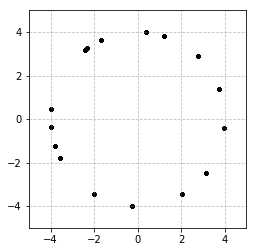

In [321]:





AT = DT.detach().cpu().numpy()
norm = np.linalg.norm(AT,axis=1,ord=2)

x = (M**0.5)* (AT[:,0] / norm)
y = (M**0.5)* (AT[:,1] / norm)

plt.scatter(x, y,c='black', s=5)

plt.grid(True, color='gray', alpha=0.5, linestyle='--')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

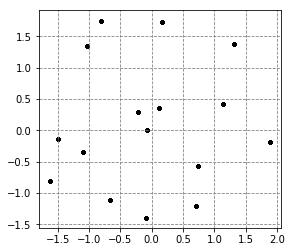

[-0.27009565  3.155951    2.76708    ... -3.9838412  -2.031063
 -2.426581  ]


In [322]:
x_mean = np.mean(AT[:,0]**2)
y_mean = np.mean(AT[:,1]**2)

x_n = AT[:,0]/x_mean**0.5
y_n = AT[:,1]/y_mean**0.5

plt.scatter(x_n, y_n,c='black', s=5)

plt.grid(True, color='gray', alpha=1, linestyle='--')
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

print(x)